<a href="https://colab.research.google.com/github/vinjamuri0807/PR_Project/blob/main/MobileNet_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Facial Expression Recognisation using MobileNet**

Import the FER2013 data from the the location /kaggle/input

Done By

Venkata Sai Anirudh Vinjamuri - 032170981



In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fer2013:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F786787%2F1351797%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240514%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240514T221515Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1cf6825ccf7826327e1f9f884c07e85734ad3a8543e5474b708a21e632f58a893302d3f21a2813bfba1ad86bfc7ad3ea47108d7c612145dae17c2b835d6a3055017de36041df378cf7fdf7f0ecaeeb48f1caf65b15a744d42ac93de737fc1ecc63f47f2f6cf6c1627adf983d221b03ef6dbcae853cc7f01853666b7f0d653e5110dd3ab2792a31b2b1c3b4029a0b8438b88699e6a7d8e2a9fe05d8c747bd2289a984007678b3a1a9f19902d78752a1c4c83c9cf39e62db981007f8aded20d9701e41f0797f680a0765227907faf2802689b82011d828807e2f045fea73cb2bed17eaadf7608685a4bc152481a7895cccf671ddcd0bc99db1f0ba4f135c15b1a7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 63252113 bytes downloaded
Downloaded and uncompressed: fer2013
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd

import os


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,
    Activation
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
def no_of_subdirs(directory,set_name):
    counts={}
    for item in os.listdir(directory):
        item_path=os.path.join(directory,item)
        if os.path.isdir(item_path):
            counts[item]=len(os.listdir(item_path))
    df=pd.DataFrame(counts,index=[set_name])
    return df

In [ ]:
train_dataset='../input/fer2013/train'
test_dataset='../input/fer2013/test'
train_count=no_of_subdirs(train_dataset,'train')
test_count=no_of_subdirs(test_dataset,'test')
print(train_count)
print(test_count)

       surprise  fear  angry  neutral   sad  disgust  happy
train      3171  4097   3995     4965  4830      436   7215
      surprise  fear  angry  neutral   sad  disgust  happy
test       831  1024    958     1233  1247      111   1774


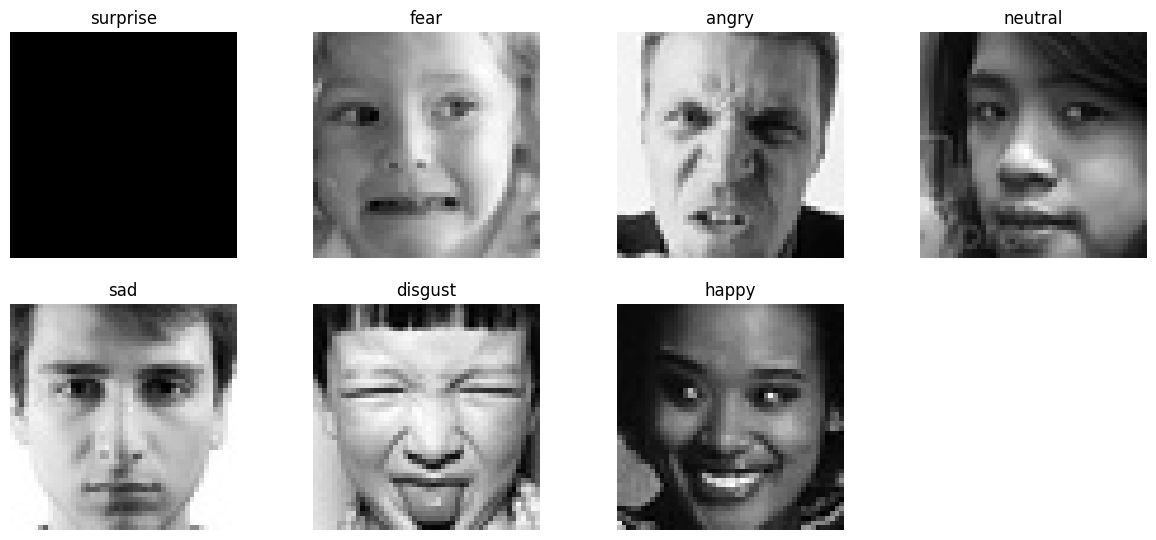

In [ ]:
emotions=os.listdir(train_dataset)
plt.figure(figsize=(15,10))
for i,emotion in enumerate(emotions,1):
    folder=os.path.join(train_dataset,emotion)
    img_path=os.path.join(folder,os.listdir(folder)[6])
    img=plt.imread(img_path)
    plt.subplot(3,4,i)
    plt.imshow(img,cmap='gray')
    plt.title(emotion)
    plt.axis('off')

## Defining Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

##Loading Datasets

In [ ]:
# Load datasets
def load_dataset(directory, subset, target_size, batch_size, class_mode):
    return train_datagen.flow_from_directory(
        directory=directory,
        target_size=target_size,
        class_mode=class_mode,
        subset=subset,
        batch_size=batch_size
    )

train_dataset = load_dataset(
    '../input/fer2013/train',
    'training',
    (48, 48),
    64,
    'categorical'
)
valid_dataset = load_dataset(
    '../input/fer2013/train',
    'validation',
    (48, 48),
    64,
    'categorical'
)

test_dataset = load_dataset(
    '../input/fer2013/test',
    None,
    (48, 48),
    64,
    'categorical'
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


##Resampling the Dataset

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.array(train_dataset.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


##Defining the MobileNet model

In [ ]:
from keras.applications import MobileNet
from tensorflow.keras import layers, models

def build_mobilenet(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                 include_top=False,
                                                 weights='imagenet',
                                                 pooling='avg')
    base_model.trainable = False  # Freeze the base model to utilize its pre-trained features

    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)  # Use the base model as a feature extractor

    # Additional custom dense layers
    x = layers.Dense(512, activation='relu')(x)  # First additional dense layer
    x = layers.Dropout(0.5)(x)  # Dropout for regularization
    x = layers.Dense(256, activation='relu')(x)  # Second dense layer
    x = layers.Dense(128, activation='relu')(x)  # Third dense layer
    x = layers.Dense(64, activation='relu')(x)  # Fourth dense layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Output layer

    model = models.Model(inputs, outputs)
    return model

model = build_mobilenet((48, 48, 3), 7)  # Model instantiated with 48x48 RGB images as input


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.build(input_shape=(None, 48, 48, 3))

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                             

In [ ]:
def f1_score(y_true, y_pred):
    # Calculate True Positives
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))

    # Calculate Possible Positives and Predicted Positives
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))

    # Calculate Precision and Recall
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())

    # Calculate F1 Score
    f1_val = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    return f1_val


In [ ]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    f1_score,
]

lrd = ReduceLROnPlateau(
    monitor='val_loss',
    patience=20,
    verbose=1,
    factor=0.50,
    min_lr=1e-10
)

mcp = ModelCheckpoint('model.keras')

es = EarlyStopping(
    verbose=1,
    patience=20
)

## Compile and train the model

In [ ]:

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=METRICS
)

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=20,
    class_weight=class_weights_dict,
    verbose=1,
    callbacks=[lrd, mcp, es]
)

Epoch 1/20
359/359 [==============================] - 64s 164ms/step - loss: 1.8443 - accuracy: 0.8572 - precision: 0.5026 - recall: 0.0300 - auc: 0.6361 - f1_score: 0.0555 - val_loss: 1.7807 - val_accuracy: 0.8579 - val_precision: 0.6053 - val_recall: 0.0160 - val_auc: 0.6910 - val_f1_score: 0.0310 - lr: 0.0010
Epoch 2/20
359/359 [==============================] - 68s 189ms/step - loss: 1.7352 - accuracy: 0.8572 - precision: 0.5009 - recall: 0.0483 - auc: 0.6820 - f1_score: 0.0869 - val_loss: 1.7298 - val_accuracy: 0.8595 - val_precision: 0.5908 - val_recall: 0.0538 - val_auc: 0.7089 - val_f1_score: 0.0974 - lr: 0.0010
Epoch 3/20
359/359 [==============================] - 56s 157ms/step - loss: 1.6492 - accuracy: 0.8577 - precision: 0.5141 - recall: 0.0668 - auc: 0.7122 - f1_score: 0.1167 - val_loss: 1.7232 - val_accuracy: 0.8585 - val_precision: 0.5376 - val_recall: 0.0685 - val_auc: 0.7109 - val_f1_score: 0.1201 - lr: 0.0010
Epoch 4/20
359/359 [==============================] - 56s 

## Model Performance Analysis

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=history.epoch,
                         y=history.history['accuracy'],
                         name='Accuracy'))
fig.add_trace(go.Scatter(x=history.epoch,
                         y=history.history['val_accuracy'],
                         name='Validation Accuracy'))
fig.update_layout(title='Training and Validation Accuracy',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy',
                  legend=dict(x=0.7, y=0.9),
                  width=800,
                  height=600,
                  plot_bgcolor='rgb(17, 17, 17)',
                  paper_bgcolor='rgb(17, 17, 17)',
                  font=dict(color='white'))
fig.show()

In [ ]:
print("\nEvaluating the model on the test dataset...")
test_loss, test_accuracy, test_precision, test_recall, test_auc, test_f1_score = model.evaluate(test_dataset)
training_loss, training_accuracy, training_precision, training_recall, training_auc, training_f1_score = model.evaluate(train_dataset)


print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")
print(f"Training Loss: {training_loss:.4f}")
print(f"Training Accuracy: {training_accuracy:.4f}")


Evaluating the model on the test dataset...
359/359 [==============================] - 40s 111ms/step - loss: 0.8225 - accuracy: 0.9226 - precision: 0.9094 - recall: 0.5089 - auc: 0.9523 - f1_score: 0.6506

Test Loss: 1.6071
Test Accuracy: 0.8638
Test Precision: 0.5544
Test Recall: 0.2385
Test AUC: 0.7916
Test F1 Score: 0.3319
Training Loss: 0.8225
Training Accuracy: 0.9226


Classification Report:
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14       958
     disgust       0.00      0.00      0.00       111
        fear       0.16      0.14      0.15      1024
       happy       0.24      0.23      0.24      1774
     neutral       0.18      0.26      0.21      1233
         sad       0.18      0.13      0.15      1247
    surprise       0.13      0.13      0.13       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.15      7178
weighted avg       0.18      0.18      0.18      7178



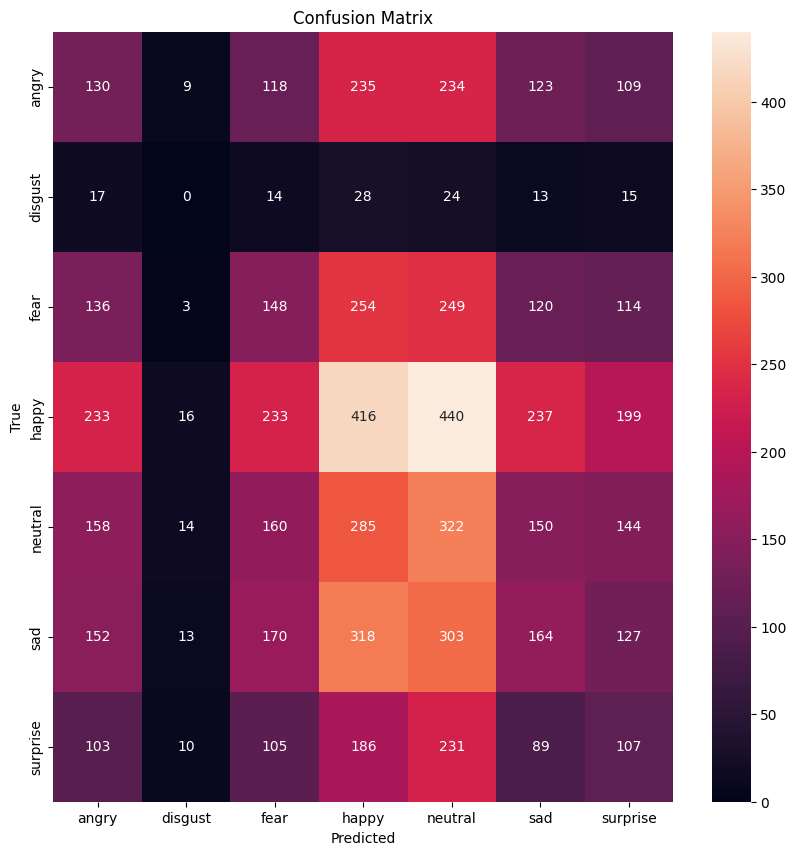

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

predictions = model.predict(test_dataset, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_dataset.classes
class_labels = list(test_dataset.class_indices.keys())

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

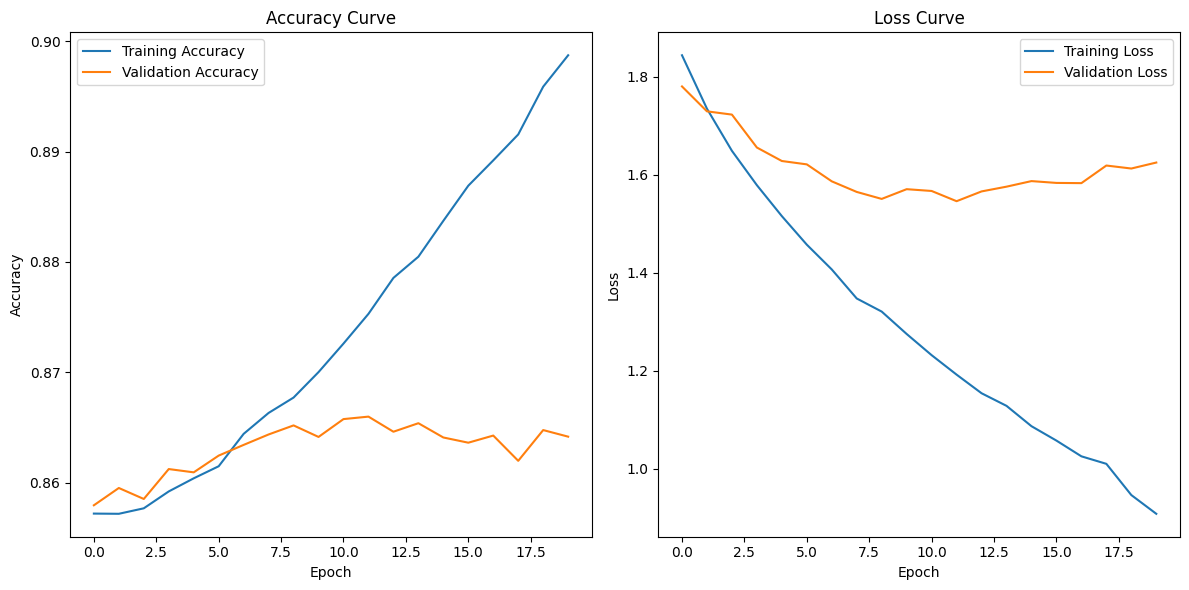

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

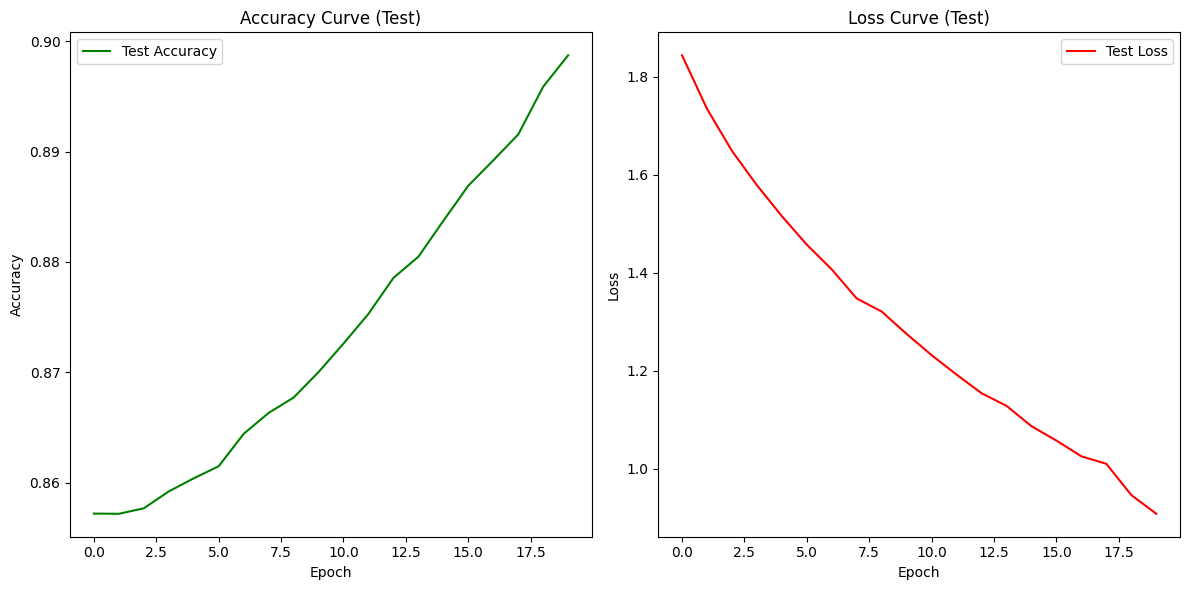

In [ ]:
plt.figure(figsize=(12, 6))

# Plot Test Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Test Accuracy', color='green')
plt.title('Accuracy Curve (Test)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Test Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Test Loss', color='red')
plt.title('Loss Curve (Test)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):

    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()

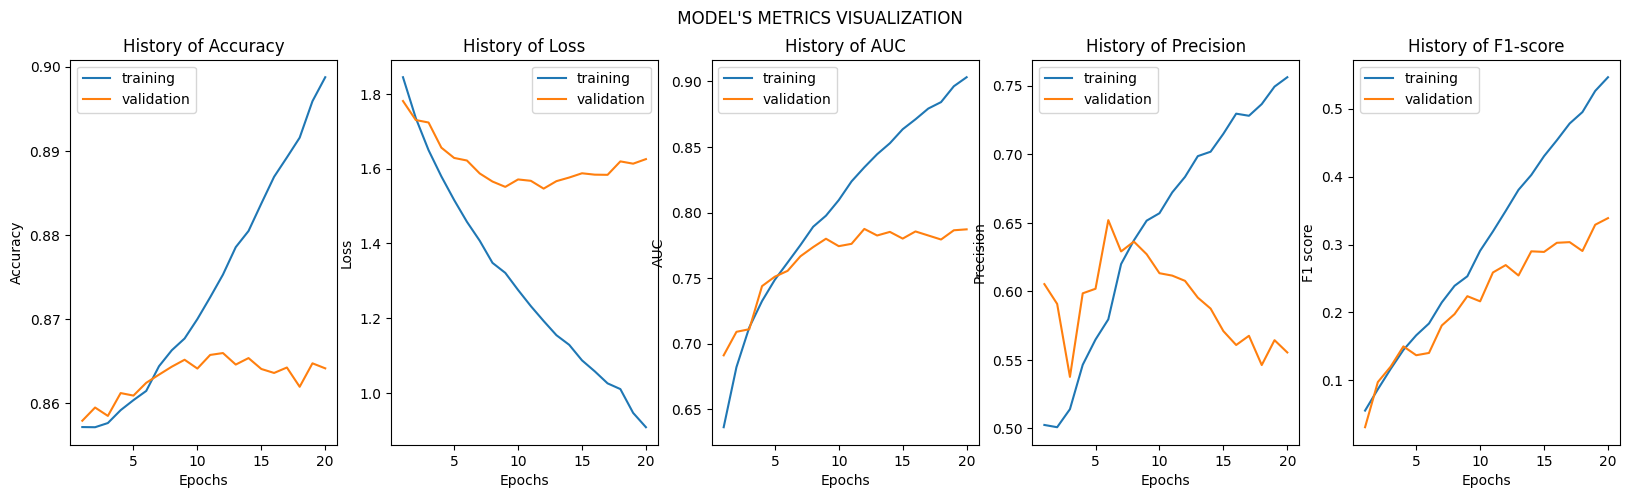

In [ ]:

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

## Model Testing Results

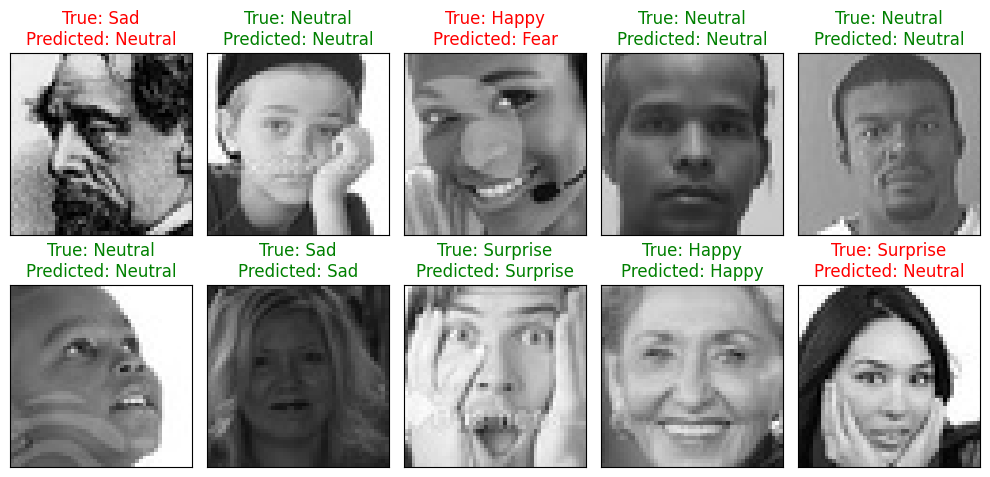

In [ ]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_dataset.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_dataset) - 1)

# Selectaing random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_dataset[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_dataset[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()
